# Quarter-Mile Race from Standing Start: RWD vs AWD
This notebook simulates a standing-start quarter-mile race (402.336 m) between two cars with configurable advanced powertrains.
## What you can customize per car
- Powertrain type (`ICE`, `PHEV`, `BEV`)
- Weight (`mass`), drivetrain (`RWD` or `AWD`), tires, and aero
- ICE torque curve, gear ratios, final drive, and shift behavior
- Manual shift time with zero wheel power during shifts
- Powertrain and driveline efficiencies so wheel power is always below source power
The notebook includes:
- Acceleration behavior comparison
- Speed vs Time plot
- Distance vs Time plot

In [100]:
import numpy as np
import matplotlib.pyplot as plt
# Constants
g = 9.81                     # m/s^2
rho_air = 1.225             # kg/m^3
quarter_mile_m = 402.336    # m
# Time integration step
dt = 0.01

In [101]:
# Single place to customize both cars
car_specs = {
    "RWD Car": {
        "powertrain_type": "ICE",
        "mass": 1500,
        "drivetrain": "RWD",
        "tire_width_mm": 300,
        "tire_compound": "summer",
        "base_mu": 1.1,
        "CdA": 0.66,
        "wheel_radius_m": 0.335,
        "rolling_resistance": 0.015,
        "ice": {
            "gearbox_type": "manual",
            "gear_ratios": [3.10, 2.10, 1.55, 1.22, 1.00, 0.82],
            "final_drive": 3.73,
            "idle_rpm": 900,
            "launch_rpm": 2800,
            "shift_rpm": 6900,
            "redline_rpm": 7200,
            "shift_time_s": 0.50,
            "engine_efficiency": 0.36,
            "driveline_efficiency": 0.90,
            "torque_curve_rpm_nm": [[1000, 380], [2000, 470], [3000, 760], [4000, 710], [5000, 620], [6000, 590], [7000, 580]]
        }
    },
    "AWD Car": {
        "powertrain_type": "PHEV",
        "mass": 2400,
        "drivetrain": "AWD",
        "tire_width_mm": 300,
        "tire_compound": "summer",
        "base_mu": 1.05,
        "CdA": 0.68,
        "wheel_radius_m": 0.350,
        "rolling_resistance": 0.016,
        "ice": {
            "gearbox_type": "auto",
            "gear_ratios": [4.70, 3.10, 2.10, 1.67, 1.28, 1.00, 0.84],
            "final_drive": 3.20,
            "idle_rpm": 850,
            "launch_rpm": 2200,
            "shift_rpm": 6200,
            "redline_rpm": 6500,
            "shift_time_s": 0.0,
            "engine_efficiency": 0.38,
            "driveline_efficiency": 0.91,
            "torque_curve_rpm_nm": [[1000, 300], [2000, 460], [3000, 600], [4000, 680], [5000, 700], [6000, 670], [6500, 620]]
        },
        "motor": {
            "single_speed_ratio": 9.0,
            "max_rpm": 16000,
            "motor_efficiency": 0.92,
            "inverter_efficiency": 0.96,
            "torque_curve_rpm_nm": [[0, 420], [2000, 420], [5000, 400], [8000, 330], [12000, 230], [16000, 150]]
        },
        "hybrid": {
            "ev_assist_end_kph": 140.0,
            "min_ev_assist": 0.10
        }
    }
}
bev_template = {
    "powertrain_type": "BEV",
    "mass": 2100,
    "drivetrain": "AWD",
    "tire_width_mm": 295,
    "tire_compound": "summer",
    "base_mu": 1.05,
    "CdA": 0.57,
    "wheel_radius_m": 0.355,
    "rolling_resistance": 0.014,
    "motor": {
        "single_speed_ratio": 9.5,
        "max_rpm": 18000,
        "motor_efficiency": 0.93,
        "inverter_efficiency": 0.97,
        "torque_curve_rpm_nm": [[0, 900], [3000, 900], [7000, 760], [12000, 520], [16000, 340], [18000, 220]]
    }
}

In [102]:
# --- Advanced physics/model functions ---
DRIVETRAIN_BASE = {"RWD": {"drive_factor": 0.93}, "AWD": {"drive_factor": 1.00}}
TIRE_COMPOUND_GRIP = {"all_season": 0.95, "summer": 1.00, "track": 1.08, "drag_radial": 1.15}
def tire_grip_multiplier(tire_width_mm, tire_compound="summer"):
    width_factor = (tire_width_mm / 245.0) ** 0.30
    width_factor = float(np.clip(width_factor, 0.90, 1.18))
    return width_factor * TIRE_COMPOUND_GRIP.get(tire_compound, 1.00)
def interp_curve(curve_points, x_value):
    points = np.array(curve_points, dtype=float)
    return float(np.interp(x_value, points[:, 0], points[:, 1]))
def wheel_rpm_from_speed(v, wheel_radius_m):
    return (v / max(wheel_radius_m, 0.2)) * 60.0 / (2.0 * np.pi)
def get_gear_ratio(car, gear_index):
    ratios = car["ice"]["gear_ratios"]
    idx = int(np.clip(gear_index, 0, len(ratios) - 1))
    return ratios[idx]
def make_car(name, spec):
    drivetrain = spec["drivetrain"].upper()
    tire_factor = tire_grip_multiplier(spec["tire_width_mm"], spec.get("tire_compound", "summer"))
    car = {
        "name": name,
        "powertrain_type": spec["powertrain_type"].upper(),
        "mass": float(spec["mass"]),
        "drivetrain": drivetrain,
        "CdA": float(spec["CdA"]),
        "wheel_radius_m": float(spec.get("wheel_radius_m", 0.34)),
        "rolling_resistance": float(spec.get("rolling_resistance", 0.015)),
        "mu": float(spec.get("base_mu", 1.05)) * tire_factor,
        "drive_factor": DRIVETRAIN_BASE[drivetrain]["drive_factor"],
        "tire_width_mm": float(spec["tire_width_mm"]),
        "tire_compound": spec.get("tire_compound", "summer")
    }
    if "ice" in spec:
        ice = dict(spec["ice"])
        ice["gearbox_type"] = ice.get("gearbox_type", "auto").lower()
        ice["gear_ratios"] = [float(x) for x in ice["gear_ratios"]]
        car["ice"] = ice
    if "motor" in spec:
        motor = dict(spec["motor"])
        motor["single_speed_ratio"] = float(motor.get("single_speed_ratio", 9.0))
        car["motor"] = motor
    if "hybrid" in spec:
        car["hybrid"] = dict(spec["hybrid"])
    return car
cars = {name: make_car(name, spec) for name, spec in car_specs.items()}
def initialize_state(car):
    return {"gear_index": 0, "in_shift": False, "shift_timer_s": 0.0, "pending_gear_index": 0, "shift_count": 0, "engine_rpm": 0.0, "motor_rpm": 0.0}
def ice_drive_force(v, car, state):
    ice = car["ice"]
    ratio = get_gear_ratio(car, state["gear_index"])
    fd = float(ice["final_drive"])
    engine_rpm = wheel_rpm_from_speed(v, car["wheel_radius_m"]) * ratio * fd
    if v < 1.5:
        engine_rpm = max(engine_rpm, float(ice.get("launch_rpm", ice.get("idle_rpm", 900))))
    else:
        engine_rpm = max(engine_rpm, float(ice.get("idle_rpm", 900)))
    engine_rpm = min(engine_rpm, float(ice.get("redline_rpm", 7000)))
    state["engine_rpm"] = engine_rpm
    engine_torque = interp_curve(ice["torque_curve_rpm_nm"], engine_rpm)
    wheel_torque = engine_torque * ratio * fd * float(ice.get("engine_efficiency", 0.36)) * float(ice.get("driveline_efficiency", 0.90))
    return wheel_torque / max(car["wheel_radius_m"], 0.2)
def motor_drive_force(v, car, state):
    motor = car["motor"]
    ratio = float(motor.get("single_speed_ratio", 9.0))
    motor_rpm = wheel_rpm_from_speed(v, car["wheel_radius_m"]) * ratio
    motor_rpm = min(motor_rpm, float(motor.get("max_rpm", 18000)))
    state["motor_rpm"] = motor_rpm
    motor_torque = interp_curve(motor["torque_curve_rpm_nm"], motor_rpm)
    wheel_torque = motor_torque * ratio * float(motor.get("motor_efficiency", 0.92)) * float(motor.get("inverter_efficiency", 0.96))
    return wheel_torque / max(car["wheel_radius_m"], 0.2)
def maybe_schedule_shift(v, car, state):
    if "ice" not in car:
        return
    ice = car["ice"]
    ratios = ice["gear_ratios"]
    if state["in_shift"]:
        return
    if state["gear_index"] >= len(ratios) - 1:
        return
    if state["engine_rpm"] >= float(ice.get("shift_rpm", ice.get("redline_rpm", 7000))):
        state["pending_gear_index"] = state["gear_index"] + 1
        gearbox_type = ice.get("gearbox_type", "auto")
        if gearbox_type == "manual":
            state["in_shift"] = True
            state["shift_timer_s"] = float(ice.get("shift_time_s", 0.30))
            state["shift_count"] += 1
        else:
            state["gear_index"] = state["pending_gear_index"]
            state["shift_count"] += 1
def propulsion_force(v, car, state, dt_step):
    if car["powertrain_type"] == "ICE":
        if state["in_shift"]:
            state["shift_timer_s"] -= dt_step
            if state["shift_timer_s"] <= 0.0:
                state["in_shift"] = False
                state["gear_index"] = state["pending_gear_index"]
            return 0.0
        force = ice_drive_force(v, car, state)
        maybe_schedule_shift(v, car, state)
        return force
    if car["powertrain_type"] == "BEV":
        return motor_drive_force(v, car, state)
    if car["powertrain_type"] == "PHEV":
        if state["in_shift"]:
            state["shift_timer_s"] -= dt_step
            if state["shift_timer_s"] <= 0.0:
                state["in_shift"] = False
                state["gear_index"] = state["pending_gear_index"]
            engine_force = 0.0
        else:
            engine_force = ice_drive_force(v, car, state)
            maybe_schedule_shift(v, car, state)
        motor_force = motor_drive_force(v, car, state)
        hybrid = car.get("hybrid", {})
        end_speed = float(hybrid.get("ev_assist_end_kph", 140.0)) / 3.6
        min_assist = float(hybrid.get("min_ev_assist", 0.10))
        assist = max(min_assist, 1.0 - v / max(end_speed, 1.0))
        return engine_force + assist * motor_force
    return 0.0
def acceleration_and_state(v, car, state, dt_step):
    drive_force = propulsion_force(v, car, state, dt_step)
    traction_force_max = car["mu"] * car["mass"] * g * car["drive_factor"]
    usable_force = min(drive_force, traction_force_max)
    drag_force = 0.5 * rho_air * car["CdA"] * v**2
    rolling_force = car["rolling_resistance"] * car["mass"] * g
    net_force = usable_force - drag_force - rolling_force
    return net_force / car["mass"]
def simulate_quarter_mile(car, dt=0.01, distance_target=quarter_mile_m):
    t = 0.0
    x = 0.0
    v = 0.0
    state = initialize_state(car)
    times = [t]
    distances = [x]
    speeds = [v]
    accels = [0.0]
    gears = [state["gear_index"] + 1]
    engine_rpms = [0.0]
    motor_rpms = [0.0]
    while x < distance_target and t <= 60.0:
        a = acceleration_and_state(v, car, state, dt)
        v = max(0.0, v + a * dt)
        x = x + v * dt
        t = t + dt
        times.append(t)
        distances.append(x)
        speeds.append(v)
        accels.append(a)
        gears.append(state["gear_index"] + 1)
        engine_rpms.append(state["engine_rpm"])
        motor_rpms.append(state["motor_rpm"])
    return {
        "time": np.array(times),
        "distance": np.array(distances),
        "speed": np.array(speeds),
        "accel": np.array(accels),
        "gear": np.array(gears),
        "engine_rpm": np.array(engine_rpms),
        "motor_rpm": np.array(motor_rpms),
        "elapsed_time": t,
        "trap_speed": v,
        "shift_count": state["shift_count"]
    }

In [103]:
results = {name: simulate_quarter_mile(spec, dt=dt) for name, spec in cars.items()}
for name, r in results.items():
    car = cars[name]
    summary = f"{name} | {car['powertrain_type']} | {car['drivetrain']} | {car['tire_width_mm']:.0f}mm {car['tire_compound']}"
    if car['powertrain_type'] in ['ICE', 'PHEV']:
        summary += f" | {car['ice']['gearbox_type']} {len(car['ice']['gear_ratios'])}spd | shifts={r['shift_count']}"
    print(summary)
    print(f"  mass={car['mass']:.0f}kg -> ET={r['elapsed_time']:.2f}s, trap={r['trap_speed']*3.6:.1f} km/h")
winner = min(results.items(), key=lambda kv: kv[1]['elapsed_time'])[0]
print(f"\nWinner over quarter mile: {winner}")

RWD Car | ICE | RWD | 300mm summer | manual 6spd | shifts=2
  mass=1500kg -> ET=16.18s, trap=149.4 km/h
AWD Car | PHEV | AWD | 300mm summer | auto 7spd | shifts=3
  mass=2400kg -> ET=14.39s, trap=151.1 km/h

Winner over quarter mile: AWD Car


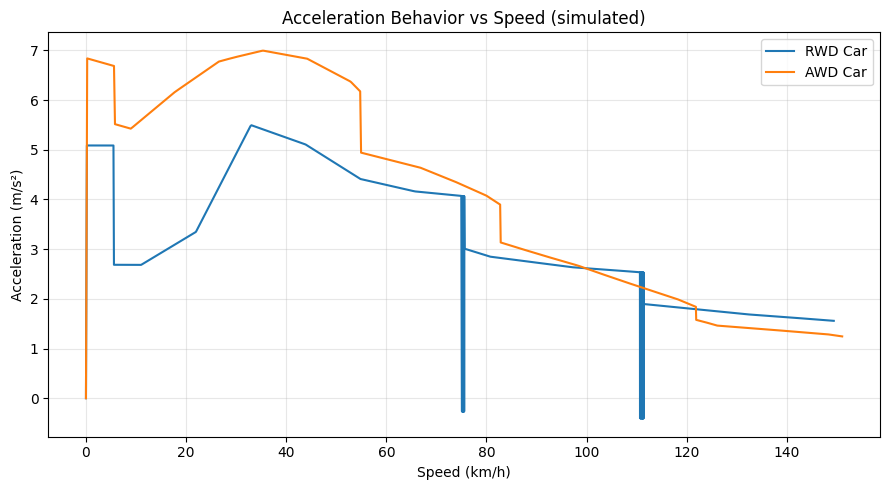

In [104]:
# 1) Acceleration behavior from time-simulated samples
results = {name: simulate_quarter_mile(spec, dt=dt) for name, spec in cars.items()}
plt.figure(figsize=(9, 5))
for name, r in results.items():
    speed_kph = r['speed'] * 3.6
    accel = r['accel']
    order = np.argsort(speed_kph)
    plt.plot(speed_kph[order], accel[order], label=name)
plt.title("Acceleration Behavior vs Speed (simulated)")
plt.xlabel("Speed (km/h)")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

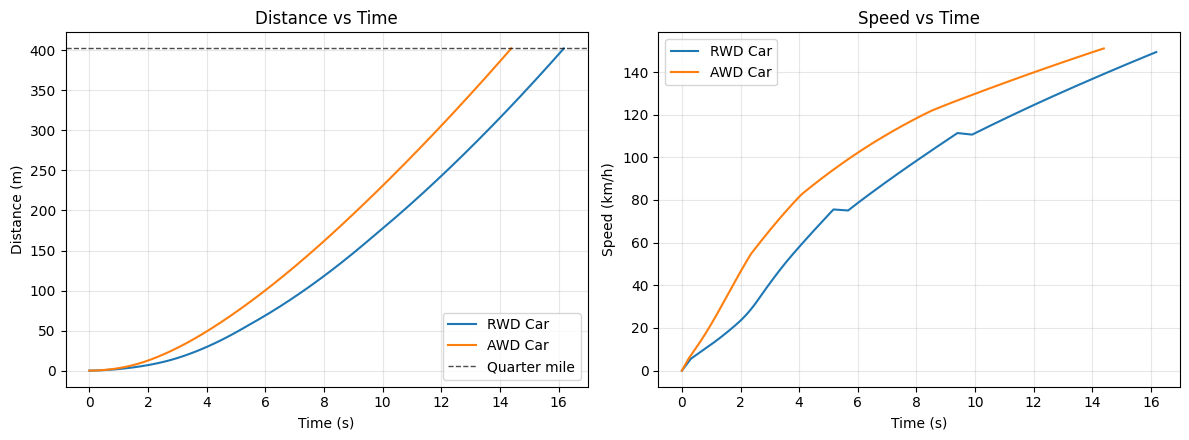

In [105]:
# 3) Race plots together: distance vs time and speed vs time
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
for name, r in results.items():
    axes[0].plot(r['time'], r['distance'], label=name)
    axes[1].plot(r['time'], r['speed'] * 3.6, label=name)
axes[0].axhline(quarter_mile_m, linestyle='--', linewidth=1.0, color='k', alpha=0.7, label='Quarter mile')
axes[0].set_title("Distance vs Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Distance (m)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[1].set_title("Speed vs Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Speed (km/h)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.tight_layout()
plt.show()

## Notes
- Edit the `car_specs` dictionary in Cell 3 to set your own specs.
- `powertrain_type` supports `ICE`, `PHEV`, and `BEV`.
- Manual shifts use a zero-wheel-power shift window (`shift_time_s`).
- Wheel power includes efficiency losses and is lower than source power.
- `bev_template` in Cell 3 can be copied into `car_specs` to compare against ICE/PHEV.